## Butterworth Filter
This program is used for analyzing sound file frequency, then calculate the butterworth filter coefficient, after that use that coefficient to filter the sound sound.

### Import
import essentials library and audio file

In [2]:
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import math
import pandas as pd
from scipy.fftpack import fft, fftfreq, ifft
y = pd.read_csv("C:/Users/ASUS/Documents/GitHub/sound-noise-reduction-signal-processing/ESP32-INMP441-ArduinoIDE/sound_samples_voicenoised.csv")

### Frequency analysis
analyze sound in time domain and frequency domain using FFT

<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:22: SyntaxWarning: invalid escape sequence '\h'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:22: SyntaxWarning: invalid escape sequence '\h'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7840\1789949389.py:21: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega$ (cycles/s)")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7840\1789949389.py:22: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$|\hat{y}|$")


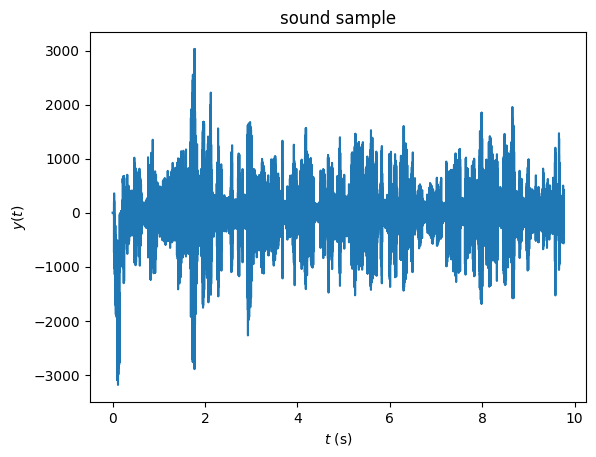

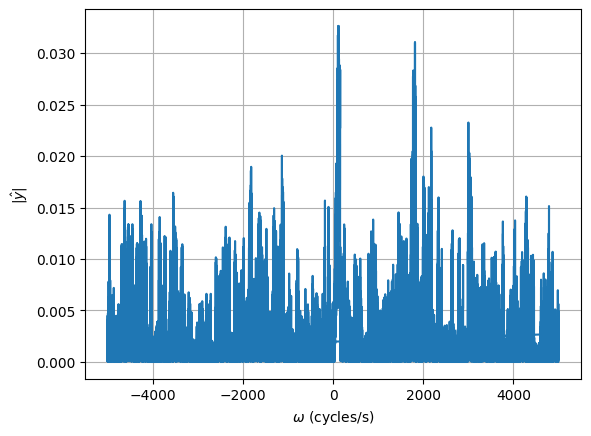

In [3]:
samplingFreq = 10000 # sampled at 10 kHz frequency = 10000 sample/s
tlims = [0,10]       # time duration in second (s)
time = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)

# compute spectrum
yhat=fft(y)
fcycles=fftfreq(len(y),1/samplingFreq)

# plot sound signals
plt.figure()
plt.plot(time[:len(y)], y)
plt.title("sound sample")
plt.ylabel("$y(t)$");
plt.xlabel("$t$ (s)");

# plot fft result
plt.figure()
plt.plot(fcycles,np.absolute(yhat)/len(y))
plt.xlabel("$\omega$ (cycles/s)")
plt.ylabel("$|\hat{y}|$")
plt.grid()

### Calculate filter coefficient
calculate the butterworth filter coefficient that fit with audio

In [4]:
# Butterworth filter
wc = 2*np.pi*4900; # Cut-off frequency (rad/s), for now our fc = 4900 Hz
n = 2;          # # n = Filter Order

# Calculate Butterworth filter coefficient
a = np.zeros(n+1)
gamma = np.pi/(2.0*n)
a[0] = 1; # first coefficient always 1
for k in range(0,n):
    rfac = np.cos(k*gamma)/np.sin((k+1)*gamma)
    a[k+1] = rfac*a[k]; 

print("Koef. Polinomial Butterworth (a_i):                              " + str(a))

# Adjust the cutoff frequency
c = np.zeros(n+1)
for k in range(0,n+1):
    c[n-k] = a[k]/pow(wc,k)

print("Koef. Polinomial Butterworth dengan Penyesuaian frekuensi (c_i): " + str(c))

Koef. Polinomial Butterworth (a_i):                              [1.         1.41421356 1.        ]
Koef. Polinomial Butterworth dengan Penyesuaian frekuensi (c_i): [1.05498942e-09 4.59345059e-05 1.00000000e+00]


In [5]:
# Low-pass filter
w0 = 2*np.pi*4900; # cut-off frequency (rad/s), the formula is omega = 2.π.fc
num = [1];      # numerator of the transfer function
den = c;        # denominator of transfer function
lowPass = signal.TransferFunction(num,den) # Generate transfer function


In [21]:
lowPass

TransferFunctionContinuous(
array([9.47876807e+08]),
array([1.00000000e+00, 4.35402528e+04, 9.47876807e+08]),
dt: None
)

<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\o'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7840\880636278.py:23: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Phase ($^\circ$)")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7840\880636278.py:24: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega$ (rad/s)")


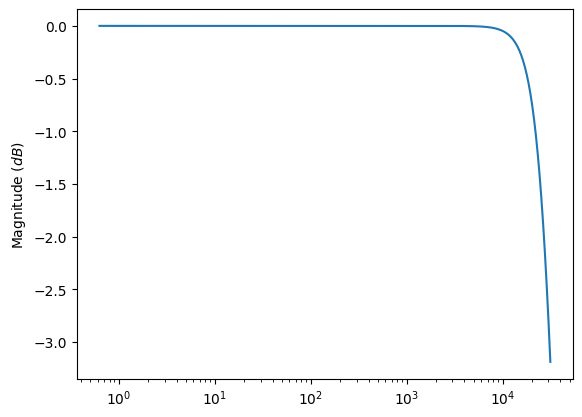

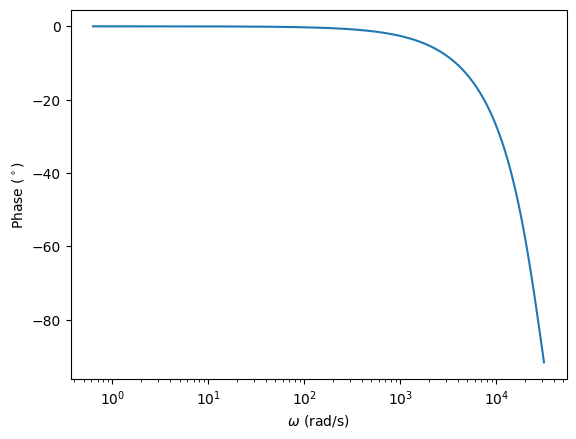

In [20]:
# Generate the bode plot
min_freq = 0.1   # Minimum frequency in Hz
max_freq = 5000  # Maximum frequency in Hz
w = np.logspace(
    np.log10(min_freq * 2 * np.pi),  # Minimum angular frequency (rad/s)
    np.log10(max_freq * 2 * np.pi),  # Maximum angular frequency (rad/s)
    500                              # Number of points for smooth plotting
)

# w = np.logspace(np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
w, mag, phase = signal.bode(lowPass,w)

# Plot Magnitude
plt.figure()
plt.semilogx(w, mag)
plt.ylabel("Magnitude ($dB$)")

# Plot Fase
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.ylabel("Phase ($^\circ$)")
plt.xlabel("$\omega$ (rad/s)")
plt.show()

### DISCRETE TRANSFER FUNCTION
To apply low-pass filter to hardware, it needs discrete transfer function. So it needs to convert the previously analog transfer function from analog domain ($s$) into digital domain ($z$). Here is how.
* If time step is $\Delta t = 1/f_s$
* Use code method <code>to_discrete</code> to calculate bilinear transformation ($\alpha = 1/2$).

In [50]:
# Convert analog transfer function to discrete transfer function with delta_t = 1/samplingFrequency
dt = 1.0/samplingFreq
discreteLowPass = lowPass.to_discrete(dt,method='gbt',alpha=0.5)
print(discreteLowPass)

TransferFunctionDiscrete(
array([0.4272252, 0.8544504, 0.4272252]),
array([1.        , 0.49387595, 0.21502486]),
dt: 0.0001
)


In [51]:
y = y.to_numpy()  # Convert to a NumPy array

### CALCULATE COEFFICIENT AND APPLY IT OFFLINE
To implement filter on a system it can be done on time domain. Transfer function representation on discrete time domain represented in differential function form that showed on Equation (4).

  $y[n] = a_1 y[n-1] + a_2 y[n-2] + ... + b_0 x[n] + b_1 x[n-1] + ...$

$...(4)$

Differential function can be obtained from inverse $Z$-transformation, that previously in the form of Equation (5).

  $H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2} + \ldots}{1 - a_1 z^{-1} - a_2 z^{-2} + \ldots}$ $...(5)$

(where $b$ and $a$ is the filter coefficient generated previously)

Compared with coefficient obtained from transfer function using this code:
<code>
num = [b_0, b_1, b_2]
den = [1, a_1, a_2]
</code>
the result is:
$$H(z) = \frac{b_0 z^2 + b_1 z + b_2}{z^2 + a_1 z + a_2}$$
where this is equal to Equation (5):
$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}$$

According to this, so the total coefficient obtained will be equal to total filter order defined in numerator dan denominator from transfer function. The difference is only at denominator coefficient sign is negative.

Other than that there are several things should be watched on the code organized:
* For signal filtering, apply coefficient using differential function (like in Equation (4)).
* Filtered signal in time domain and the power spectrum in frequency domain plotted together with raw signal (input)

Filter coefficients b_i: [0.4272252 0.8544504 0.4272252]
Filter coefficients a_i: [-0.49387595 -0.21502486]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23280\19926998.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yfilt[m] = b[0]*y[m]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23280\19926998.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i]


Text(0, 0.5, '$y(t)$')

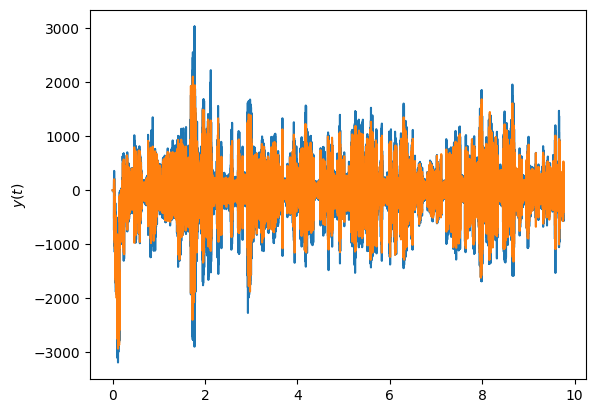

In [57]:
# Recall filter coefficient from discrete (using negative sign)
b = discreteLowPass.num
a = -discreteLowPass.den
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Apply signal filter using transfer function
Nb = len(b)
yfilt = np.zeros(len(y))
for m in range(3,len(y)):
    yfilt[m] = b[0]*y[m]
    for i in range(1,Nb):
        yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i]

# Plot the input signal x(n) and filtered output y(n)
plt.figure()
plt.plot(time[:97613],y)
plt.plot(time[:97613],yfilt)
plt.ylabel("$y(t)$")
